![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Finance/5.RelationExtraction_and_ZeroShot.ipynb)

# Financial Relation Extraction(RE) and Zero-shot Relation Extraction

## Colab Setup

In [1]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install johnsnowlabs 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.6/570.6 KB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.4/448.4 KB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 KB 230.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880769 sha256=

In [2]:
from johnsnowlabs import nlp, finance, legal, medical

nlp.install(force_browser=True)

<IPython.core.display.Javascript object>

127.0.0.1 - - [07/Jan/2023 10:50:21] "GET /login?code=vGcSNYArkOGotsKCh6w6IRLbd5YmIn HTTP/1.1" 200 -


<IPython.core.display.Javascript object>

Licenses extracted successfully
📋 Stored John Snow Labs License in /root/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
👷 Setting up  John Snow Labs home in /root/.johnsnowlabs, this might take a few minutes.
🙆 JSL Home setup in /root/.johnsnowlabs
Installing /root/.johnsnowlabs/py_installs/spark_nlp_jsl-4.2.4-py3-none-any.whl to /usr/bin/python3
Running: /usr/bin/python3 -m pip install /root/.johnsnowlabs/py_installs/spark_nlp_jsl-4.2.4-py3-none-any.whl
Installed 1 products:
💊 Spark-Healthcare==4.2.4 installed! ✅ Heal the planet with NLP! 


In [3]:
spark = nlp.start()

👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.2.4, 💊Spark-Healthcare==4.2.4, running on ⚡ PySpark==3.1.2


## Extract Acquisition and Subsidiary Relationships

This is a demonstration of using SparkNLP for extracting the following relations.

- **DATE-ORG**
- **DATE-ALIAS**
- **DATE-PRODUCT**
- **ORG-ORG**

The aim of this model is to retrieve acquisition or subsidiary relationships between Organizations, included when the acquisition was carried out **was_acquired** and by whom **was_acquired_by**. Subsidiaries are tagged with the relationship **is_subsidiary_of**.

In [ ]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl", "xx")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")
        
tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

ner_model = finance.NerModel.pretrained("finner_orgs_prods_alias","en","finance/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner_org")

ner_converter = finance.NerConverterInternal()\
    .setInputCols(["sentence","token","ner_org"])\
    .setOutputCol("ner_chunk_org")

token_classifier = nlp.DeBertaForTokenClassification.pretrained("deberta_v3_base_token_classifier_ontonotes", "en")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("ner_date")\
    .setCaseSensitive(True)\
    .setMaxSentenceLength(512) 

ner_converter_date = finance.NerConverterInternal()\
    .setInputCols(["sentence","token","ner_date"])\
    .setOutputCol("ner_chunk_date")\
    .setWhiteList(["DATE"])

chunk_merger = finance.ChunkMergeApproach()\
    .setInputCols("ner_chunk_org", "ner_chunk_date")\
    .setOutputCol('ner_chunk')

re_model = finance.RelationExtractionDLModel.pretrained("finre_acquisitions_subsidiaries_md", "en", "finance/models")\
    .setPredictionThreshold(0.3)\
    .setInputCols(["ner_chunk", "document"])\
    .setOutputCol("relations")

pipeline = nlp.Pipeline(stages=[
        document_assembler,
        sentence_detector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter,
        token_classifier,
        ner_converter_date,
        chunk_merger,
        re_model
        ])
empty_df = spark.createDataFrame([[""]]).toDF("text")

re_model = pipeline.fit(empty_df)

light_model = nlp.LightPipeline(re_model)


sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
finner_orgs_prods_alias download started this may take some time.
[OK!]
deberta_v3_base_token_classifier_ontonotes download started this may take some time.
Approximate size to download 594.3 MB
[OK!]
finre_acquisitions_subsidiaries_md download started this may take some time.
[OK!]


In [ ]:
ner_model.getClasses()

['O', 'B-ORG', 'I-ORG', 'B-ALIAS', 'I-ALIAS', 'I-PRODUCT', 'B-PRODUCT']

### Create Generic Function to Show Relations in Dataframe

In [13]:
import pandas as pd

def get_relations_df (results, col='relations'):
    rel_pairs=[]
    for i in range(len(results)):
        for rel in results[i][col]:
            rel_pairs.append((
              rel.result, 
              rel.metadata['entity1'], 
              rel.metadata['entity1_begin'],
              rel.metadata['entity1_end'],
              rel.metadata['chunk1'], 
              rel.metadata['entity2'],
              rel.metadata['entity2_begin'],
              rel.metadata['entity2_end'],
              rel.metadata['chunk2'], 
              rel.metadata['confidence']
          ))
    rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])
    return rel_df

### Getting Result with Light Pipeline

LightPipelines are Spark NLP specific Pipelines, equivalent to Spark ML Pipeline, but meant to deal with smaller amounts of data. They’re useful working with small datasets, debugging results, or when running either training or prediction from an API that serves one-off requests.
Spark NLP LightPipelines are Spark ML pipelines converted into a single machine but the multi-threaded task, becoming more than 10x times faster for smaller amounts of data (small is relative, but 50k sentences are roughly a good maximum). To use them, we simply plug in a trained (fitted) pipeline and then annotate a plain text. We don't even need to convert the input text to DataFrame in order to feed it into a pipeline that's accepting DataFrame as an input in the first place. This feature would be quite useful when it comes to getting a prediction for a few lines of text from a trained ML model.

In [ ]:
sample_text = """WhatsApp was acquired by Facebook for $19 billion in 2014. Now, WhatsApp is a subsidiary of Meta."""

In [ ]:
result = light_model.fullAnnotate(sample_text)

In [ ]:
rel_df = get_relations_df(result)

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,was_acquired_by,ORG,0,7,WhatsApp,ORG,25,32,Facebook,0.9799153
1,has_acquisition_date,ORG,0,7,WhatsApp,DATE,53,56,2014,0.9993327
2,has_acquisition_date,ORG,25,32,Facebook,DATE,53,56,2014,0.99919623


### Visualization of Extracted Relations

We use **RelationExtractionVisualizer** method of **spark-nlp-display** library for visualization fo the extracted relations between the entities.

In [ ]:
# from sparknlp_display import RelationExtractionVisualizer

re_vis = nlp.viz.RelationExtractionVisualizer()

re_vis.display(result = result[0],
               relation_col = "relations",
               document_col = "document",
               show_relations=True
               )

## Relation extraction between ORGS, PRODUCTS and their ALIASES

This model shows relations between ORG (Companies), PRODUCT (Products) and their ALIAS in financial documents.

The extracted relationships are as follows:

- **ORG-ALIAS**
- **PRODUCT-ALIAS**

In [ ]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl", "xx")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")
        
tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")
    
ner_model = finance.NerModel.pretrained("finner_orgs_prods_alias", "en", "finance/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

ner_converter = finance.NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

pos = nlp.PerceptronModel.pretrained("pos_anc", 'en')\
    .setInputCols("sentence", "token")\
    .setOutputCol("pos")
    
dependency_parser = nlp.DependencyParserModel().pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos", "token"])\
    .setOutputCol("dependencies")

re_ner_chunk_filter = finance.RENerChunksFilter()\
    .setInputCols(["ner_chunk", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setRelationPairs(["ORG-ALIAS, PRODUCT-ALIAS"])

re_model = finance.RelationExtractionDLModel.pretrained("finre_org_prod_alias", "en", "finance/models")\
    .setPredictionThreshold(0.3)\
    .setInputCols(["ner_chunk", "sentence"])\
    .setOutputCol("relations")

nlpPipeline = nlp.Pipeline(stages=[
        document_assembler,
        sentence_detector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter,
        pos,
        dependency_parser,
        re_ner_chunk_filter,
        re_model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

re_model = nlpPipeline.fit(empty_data)

light_model = nlp.LightPipeline(re_model)

sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
finner_orgs_prods_alias download started this may take some time.
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
finre_org_prod_alias download started this may take some time.
[OK!]


### Getting Result with Light Pipeline

In [ ]:
sample_text = """On March 12, 2020 we closed a Loan and Security Agreement with Hitachi Capital America Corp. ("Hitachi") the terms of which are described in this report which replaced our credit facility with Western Alliance Bank."""

result = light_model.fullAnnotate(sample_text)

rel_df = get_relations_df(result)

rel_df[rel_df["relation"] != "no_rel"]

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,has_alias,ORG,63,91,Hitachi Capital America Corp.,ALIAS,95,101,Hitachi,0.9983972
1,has_alias,ORG,63,91,Hitachi Capital America Corp.,ORG,193,213,Western Alliance Bank,0.88593066


In [ ]:
pd.DataFrame([(x.result, x.metadata["entity"]) for x in result[0]["ner_chunk"]], columns=["text", "ner"])

,text,ner
0,Hitachi Capital America Corp.,ORG
1,Hitachi,ALIAS
2,Western Alliance Bank,ORG


### Visualization of Extracted Relations

In [ ]:
# from sparknlp_display import RelationExtractionVisualizer

re_vis = nlp.viz.RelationExtractionVisualizer()

re_vis.display(result = result[0],
               relation_col = "relations",
               document_col = "document",
               exclude_relations = ["no_rel"],
               show_relations=True
               )

# Introduction to Zero-shot Relation Extraction

#### **Answering Questions on Legal Texts**
One of the latests biggest outcomes in NLP are **Language Models** and their ability to answer questions, expressed in natural language.

*On March 12, 2020 we closed a Loan and Security Agreement with Hitachi Capital America Corp. ("Hitachi") the terms of which are described in this report which replaced our credit facility with Western Alliance Bank.*

```
"has_alias": ["{ORG} has alias {ALIAS} "]
````

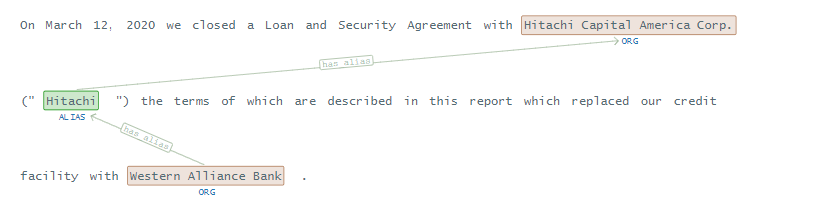



**Question Answeering (QA)** uses specific Language Models trained to carry out **Natural Language Inference (NLI)**

**NLI** works as follows:
- Given a text as a Premise (P);
- Given a hypotheses (H) as a question to be solved;
   - Then, we ask the Language Model is H is `entailed`, `contradicted` or `not related` in P. 

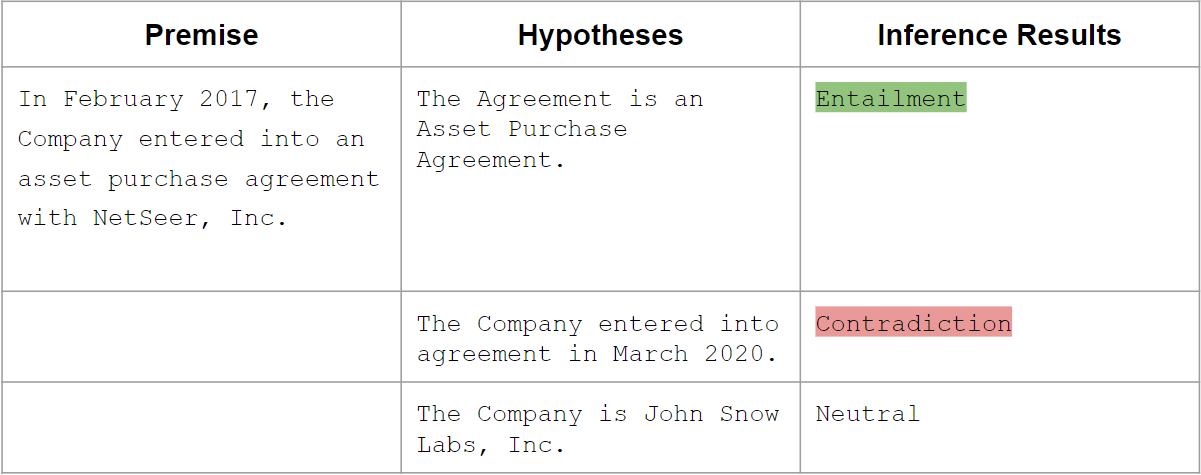

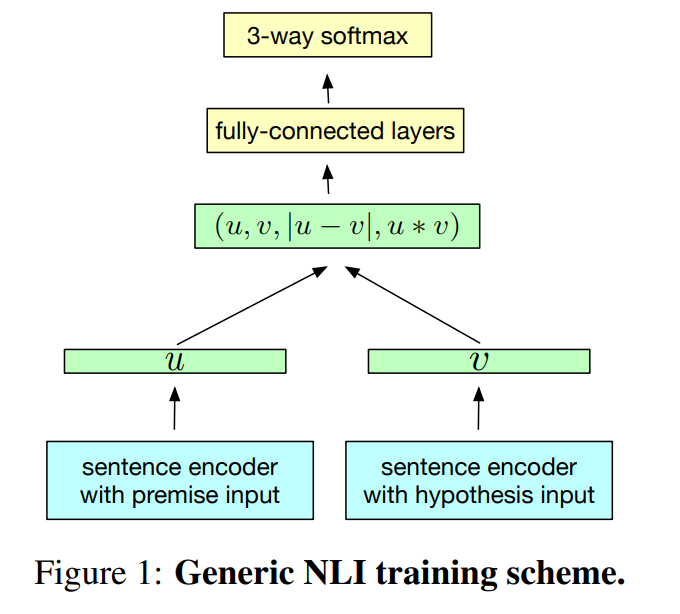

## Zero Shot Relation Extraction to Extract Relations Between Financial Entities

This is a Zero-shot Relation Extraction Model, meaning that it does not require any training data, just few examples of of the relations types you are looking for, to output a proper result.

**Make sure you keep the proper syntax of the relations you want to extract**

In [16]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl", "xx")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")
        
tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

ner_model = finance.NerModel.pretrained("finner_financial_small", "en", "finance/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")\

ner_converter = finance.NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

pos_tagger = nlp.PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")
    
dependency_parser = nlp.DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

re_ner_chunk_filter = legal.RENerChunksFilter()\
    .setInputCols(["ner_chunk", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(5)


re_model = finance.ZeroShotRelationExtractionModel.pretrained("finre_zero_shot", "en", "finance/models")\
    .setInputCols(["re_ner_chunks", "sentence"]) \
    .setPredictionThreshold(0.9)\
    .setOutputCol("relations")\
    .setMultiLabel(False)

re_model.setRelationalCategories({
    "profit_decline_by": ["{PROFIT_DECLINE} decreased by {AMOUNT} from", "{PROFIT_DECLINE} decreased by {AMOUNT} to"],
    "profit_decline_by_per": ["{PROFIT_DECLINE} decreased by a {PERCENTAGE} from", "{PROFIT_DECLINE} decreased by a {PERCENTAGE} to"],
    "profit_decline_from": ["{PROFIT_DECLINE} decreased from {AMOUNT}", "{PROFIT_DECLINE} decreased from {AMOUNT} for the year"],
    "profit_decline_from_per": ["{PROFIT_DECLINE} decreased from {PERCENTAGE} to", "{PROFIT_DECLINE} decreased from {PERCENTAGE} to a total of"],
    "profit_decline_to": ["{PROFIT_DECLINE} to {AMOUNT}"],
    "profit_increase_from": ["{PROFIT_INCREASE} from {AMOUNT}"],
    "profit_increase_to": ["{PROFIT_INCREASE} to {AMOUNT}"],    
    "expense_decrease_by": ["{EXPENSE_DECREASE} decreased by {AMOUNT}"],
    "expense_decrease_by_per": ["{EXPENSE_DECREASE} decreased by a {PERCENTAGE}"],
    "expense_decrease_from": ["{EXPENSE_DECREASE} decreased from {AMOUNT}"],    
    "expense_decrease_to": ["{EXPENSE_DECREASE} for a total of {AMOUNT} for the fiscal year"],    
    "has_date": ["{AMOUNT} for the fiscal year ended {FISCAL_YEAR}", "{PERCENTAGE} for the fiscal year ended {FISCAL_YEAR}"]
})

pipeline = nlp.Pipeline(stages =[
                document_assembler,  
                sentence_detector,
                tokenizer, 
                embeddings,
                ner_model,
                ner_converter,
                pos_tagger,
                dependency_parser,
                re_ner_chunk_filter,
                re_model
               ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

light_model = nlp.LightPipeline(model)

sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
finner_financial_small download started this may take some time.
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
finre_zero_shot download started this may take some time.
[OK!]


In [17]:
ner_model.getClasses()

['O',
 'B-PERCENTAGE',
 'B-FISCAL_YEAR',
 'I-FISCAL_YEAR',
 'B-PROFIT_INCREASE',
 'I-EXPENSE_INCREASE',
 'B-CURRENCY',
 'B-EXPENSE_INCREASE',
 'B-EXPENSE_DECREASE',
 'I-AMOUNT',
 'I-DATE',
 'I-PROFIT_INCREASE',
 'B-AMOUNT',
 'I-PROFIT_DECLINE',
 'I-CURRENCY',
 'I-EXPENSE',
 'B-DATE',
 'I-PERCENTAGE',
 'B-EXPENSE',
 'B-PROFIT_DECLINE',
 'I-PROFIT',
 'B-PROFIT',
 'I-EXPENSE_DECREASE']

In [18]:
sample_text = """License fees revenue decreased 40 %, or $ 0.5 million to $ 0.7 million for the year ended December 31, 2020 compared to $ 1.2 million for the year ended December 31, 2019. Services revenue increased 4 %, or $ 1.1 million, to $ 25.6 million for the year ended December 31, 2020 from $ 24.5 million for the year ended December 31, 2019. Costs of revenue, excluding depreciation and amortization increased by $ 0.1 million, or 2 %, to $ 8.8 million for the year ended December 31, 2020 from $ 8.7 million for the year ended December 31, 2019.  Also, a decrease in travel costs of $ 0.4 million due to travel restrictions caused by the global pandemic. As a percentage of revenue, cost of revenue, excluding depreciation and amortization was 34 % for each of the years ended December 31, 2020 and 2019. Sales and marketing expenses decreased 20 %, or $ 1.5 million, to $ 6.0 million for the year ended December 31, 2020 from $ 7.5 million for the year ended December 31, 2019"""

data = spark.createDataFrame([[sample_text]]).toDF("text")

result = model.transform(data)


**NER output**

In [19]:
result.selectExpr("explode(ner_chunk) as ner").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------+
|ner                                                                                                                                               |
+--------------------------------------------------------------------------------------------------------------------------------------------------+
|{chunk, 0, 19, License fees revenue, {chunk -> 0, confidence -> 0.56216663, ner_source -> ner_chunk, entity -> PROFIT_DECLINE, sentence -> 0}, []}|
|{chunk, 31, 32, 40, {chunk -> 1, confidence -> 1.0, ner_source -> ner_chunk, entity -> PERCENTAGE, sentence -> 0}, []}                            |
|{chunk, 40, 40, $, {chunk -> 2, confidence -> 1.0, ner_source -> ner_chunk, entity -> CURRENCY, sentence -> 0}, []}                               |
|{chunk, 42, 52, 0.5 million, {chunk -> 3, confidence -> 1.0, ner_source -> ner_chunk, entity -> AMOUNT, s

**Relations output**

In [20]:
result.selectExpr("explode(relations) as relation").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|relation                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
+-------------------------------------------------------------------------------------------------------

### Getting Result with Light Pipeline

In [21]:
result = light_model.fullAnnotate(sample_text)

rel_df = get_relations_df(result)

rel_df[rel_df["relation"] != "no_rel"]

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,expense_decrease_from,EXPENSE_DECREASE,799,826,Sales and marketing expenses,AMOUNT,923,933,7.5 million,0.9770538
1,profit_increase_to,PROFIT_INCREASE,172,187,Services revenue,AMOUNT,227,238,25.6 million,0.9674029
2,expense_decrease_by,EXPENSE_DECREASE,561,572,travel costs,AMOUNT,579,589,0.4 million,0.9946776
3,profit_increase_from,PROFIT_INCREASE,172,187,Services revenue,AMOUNT,209,219,1.1 million,0.96610945
4,profit_decline_by_per,PROFIT_DECLINE,0,19,License fees revenue,PERCENTAGE,31,32,40,0.9948003
5,expense_decrease_from,EXPENSE_DECREASE,799,826,Sales and marketing expenses,AMOUNT,867,877,6.0 million,0.98329085
6,profit_decline_by,PROFIT_DECLINE,0,19,License fees revenue,AMOUNT,59,69,0.7 million,0.9884275
7,expense_decrease_by_per,EXPENSE_DECREASE,799,826,Sales and marketing expenses,PERCENTAGE,838,839,20,0.9942433
8,profit_decline_by,PROFIT_DECLINE,0,19,License fees revenue,AMOUNT,42,52,0.5 million,0.99020004
9,has_date,AMOUNT,408,418,0.1 million,FISCAL_YEAR,465,481,"December 31, 2020",0.9017817


### Visualization of Extracted Relations

In [22]:
# from sparknlp_display import RelationExtractionVisualizer

re_vis = nlp.viz.RelationExtractionVisualizer()

re_vis.display(result = result[0],
               relation_col = "relations",
               document_col = "document",
               exclude_relations = ["no_rel"],
               show_relations=True
               )

#### Example -2

In [ ]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl", "xx")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")
        
tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

embeddings= nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en")\
        .setInputCols(["sentence", "token"])\
        .setOutputCol("bert_embeddings")

ner_model = finance.NerModel.pretrained("finner_orgs_prods_alias", "en", "finance/models")\
        .setInputCols(["sentence", "token", "bert_embeddings"])\
        .setOutputCol("ner_orgs")


ner_converter = finance.NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_orgs"])\
    .setOutputCol("ner_chunk")

re_model = finance.ZeroShotRelationExtractionModel.pretrained("finre_zero_shot", "en", "finance/models")\
    .setInputCols(["ner_chunk", "sentence"]) \
    .setOutputCol("relations")\
    .setMultiLabel(False)

re_model.setRelationalCategories({
    "has_alias": ["{ORG} has alias {ALIAS} "],
    
})

pipeline = nlp.Pipeline(stages =[
                document_assembler,  
                sentence_detector,
                tokenizer, 
                embeddings,
                ner_model,
                ner_converter,
                re_model
               ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

light_model = nlp.LightPipeline(model)

sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
finner_orgs_prods_alias download started this may take some time.
[OK!]
finre_zero_shot download started this may take some time.
[OK!]


In [ ]:
ner_model.getClasses()

['O', 'B-ORG', 'I-ORG', 'B-ALIAS', 'I-ALIAS', 'I-PRODUCT', 'B-PRODUCT']

In [ ]:
sample_text = '''
On March 12, 2020 we closed a Loan and Security Agreement with Hitachi Capital America Corp. ("Hitachi") the terms of which are described in this report which replaced our credit facility with Western Alliance Bank.
'''
data = spark.createDataFrame([[sample_text]]).toDF("text")

result = model.transform(data)


**NER output**

In [ ]:
result.selectExpr("explode(ner_chunk) as ner").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------+
|ner                                                                                                                                              |
+-------------------------------------------------------------------------------------------------------------------------------------------------+
|{chunk, 64, 92, Hitachi Capital America Corp., {chunk -> 0, confidence -> 0.63541996, ner_source -> ner_chunk, entity -> ORG, sentence -> 0}, []}|
|{chunk, 96, 102, Hitachi, {chunk -> 1, confidence -> 0.9983, ner_source -> ner_chunk, entity -> ALIAS, sentence -> 0}, []}                       |
|{chunk, 194, 214, Western Alliance Bank, {chunk -> 2, confidence -> 0.57783335, ner_source -> ner_chunk, entity -> ORG, sentence -> 0}, []}      |
+---------------------------------------------------------------------------------------------------------------

**Relations output**

In [ ]:
result.selectExpr("explode(relations) as relation").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|relation                                                                                                                                                                                                                                                                                                                                                                                                     |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Getting Result with Light Pipeline

In [ ]:
result = light_model.fullAnnotate(sample_text)

rel_df = get_relations_df(result)

rel_df[rel_df["relation"] != "no_rel"]

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,has_alias,ORG,64,92,Hitachi Capital America Corp.,ALIAS,96,102,Hitachi,0.98388344


### Visualization of Extracted Relations

In [ ]:
# from sparknlp_display import RelationExtractionVisualizer

re_vis = nlp.viz.RelationExtractionVisualizer()

re_vis.display(result = result[0],
               relation_col = "relations",
               document_col = "document",
               exclude_relations = ["no_rel"],
               show_relations=True
               )